## Try Pytorch with Digit Recognition

* Reference: https://www.analyticsvidhya.com/blog/2018/02/pytorch-tutorial/
  * <b>Some functions are wrong or out of dated which will cause so much troubles. Better to try my code below</b>.
  * However, since these deep learning open sources keep updating and deprecating functions, you will never know whether a previous tutorial works for you at the time when you try. This is one of the reasons I hate deep learning.
* To compare with Keras code in Digit Recognition: https://github.com/hanhanwu/Hanhan_Data_Science_Practice/blob/master/AI_Experiments/digital_recognition_Keras.ipynb

In [1]:
%pylab inline
import os
import numpy as np
import pandas as pd
import imageio as io
from sklearn.metrics import accuracy_score

import torch

# Get data from here: https://datahack.analyticsvidhya.com/contest/practice-problem-identify-the-digits/

Populating the interactive namespace from numpy and matplotlib


In [2]:
seed = 10
rng = np.random.RandomState(seed)

In [3]:
train = pd.read_csv('Train_digits/train.csv')
train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


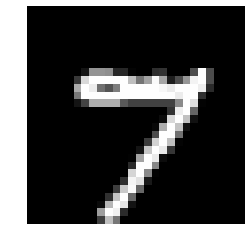

In [4]:
# randomly display an image
img_name = rng.choice(train.filename)
training_image_path = 'Train_digits/Images/train/' + img_name

training_img = io.imread(training_image_path, as_gray=True)

pylab.imshow(training_img, cmap='gray')
pylab.axis('off')
pylab.show()

In [5]:
# This is just 1 image
print(training_img.shape)
training_img[0]  # each image has 28x28 pixel square, 784 pixels in total

(28, 28)


Image([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [6]:
# store all images as numpy arrays, to make data manipulation easier

temp = []
for img_name in train.filename:
    training_image_path = 'Train_digits/Images/train/' + img_name
    training_img = io.imread(training_image_path, as_gray=True)  # !!! as_gray param makes a difference here!!
    img = training_img.astype('float32')
    temp.append(img)
    
train_x = np.stack(temp)

train_x /= 255.0
train_x = train_x.reshape(-1, 784).astype('float32')  # 784 pixels per image 

train_y = train.label.values

With `as_gray` param in `io.imread()`, it will help you get train_x, train_y have the same length. Otherwise there will be so much troubles in creating batches later.

In [8]:
print(train_x.shape)
train_x

(49000, 784)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
print(train_y.shape)  # 49000 images in total
train_y

(49000,)


array([4, 9, 1, ..., 9, 3, 0], dtype=int64)

In [10]:
# create validation set
split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train_y[:split_size], train_y[split_size:]

print(train_x.shape, train_y.shape)
print(train_x)
print(train_y)

(34300, 784) (34300,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[4 9 1 ... 4 0 6]


In [11]:
# Using Pytorch to build the model
from torch.autograd import Variable

## number of neurons in each layer
input_num_units = 28*28  # 784 pixels per image
hidden_num_units = 500
output_num_units = 10  # 0 - 9, 10 digits

## set variables used in NN
epochs = 5
batch_size = 128
learning_rate = 0.001

In [12]:
# define model
model = torch.nn.Sequential(
  torch.nn.Linear(input_num_units, hidden_num_units),
  torch.nn.ReLU(),
  torch.nn.Linear(hidden_num_units, output_num_units),
)
loss_fn = torch.nn.CrossEntropyLoss()

# define optimization algorithm
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
# preprocess a batch of dataset
def preproc(unclean_batch_x):
    """Convert values to range 0-1"""
    temp_batch = unclean_batch_x / unclean_batch_x.max()
 
    return temp_batch

# create a batch
def batch_creator(batch_size):
    dataset_name = 'train'
    dataset_length = eval(dataset_name+'_x').shape[0]
  
    batch_mask = rng.choice(dataset_length, batch_size)
  
    batch_x = eval(dataset_name+'_x')[batch_mask]
    batch_x = preproc(batch_x)
  
    batch_y = eval(dataset_name+'_y')[batch_mask]  # train_x, train_y has the same length
  
    return batch_x, batch_y

In [16]:
# train network
total_batch = int(train.shape[0]/batch_size)

for epoch in range(epochs):
    avg_cost = 0
    for i in range(total_batch):
        # create batch
        batch_x, batch_y = batch_creator(batch_size)

        # pass that batch for training
        x, y = Variable(torch.from_numpy(batch_x)), Variable(torch.from_numpy(batch_y), requires_grad=False)
        pred = model(x)

        # get loss
        loss = loss_fn(pred, y)

        # perform backpropagation
        loss.backward()
        optimizer.step()
        avg_cost += loss.data/total_batch

    print(epoch, avg_cost)

0 tensor(0.7093)
1 tensor(0.6976)
2 tensor(0.6666)
3 tensor(0.6627)
4 tensor(0.6538)


In [17]:
# get training accuracy
x, y = Variable(torch.from_numpy(preproc(train_x))), Variable(torch.from_numpy(train_y), requires_grad=False)
pred = model(x)

final_pred = np.argmax(pred.data.numpy(), axis=1)

accuracy_score(train_y, final_pred)

0.8284548104956269

In [18]:
# get validation accuracy
x, y = Variable(torch.from_numpy(preproc(val_x))), Variable(torch.from_numpy(val_y), requires_grad=False)
pred = model(x)
final_pred = np.argmax(pred.data.numpy(), axis=1)

accuracy_score(val_y, final_pred)

0.8196598639455782

## Summary

* Again, a simple deep learning problem cost me so much time to debug because of the updates in these open sources!
  * Simple param makes a difference, in this case, `imread()` from scipy got deprecated, you have to change to `imageio.imread()`, which replaced "flatten" with "as_gray", without this param, your train_x, train_y will get different length after converting to numpy array, which will cause so much trouble when creating batches later.
  * This is why I hate deep learing, software updates, and so much dimentions conversion, difficult to find problems and time consuming to debug.
* For this case, comparing with Keras, I think Pytorch is more complex to use, especially when thinking about it cost me so much time to debug when creating batches, while Keras will just do that for you! Not sure why many people are crazy about Pytorch (maybe it's better than Tensorflow...)
* When building the model, the neural network structure is easier to understand than keras, since it will show you the order between layers and the activation functions.